# Objective 
**To Classify birds based on sound recordings provided in the training set, and to predict the birds species present in the test set. The Image meta-data is given in the train_metadata.csv .**

# Resources:

* Research Paper  [ http://ceur-ws.org/Vol-1866/paper_143.pdf ]
* Guide Notebook [ https://www.kaggle.com/stefankahl/birdclef2021-model-training ]
* My notebook on Rainforest Connect Audio : [ https://www.kaggle.com/virajkadam/rainforest-connect-custom-cnn ]
* [ https://www.kaggle.com/kmldas/birdclef-2021-eda-model ]



**My notebook on BirdClef EDA:** [ https://www.kaggle.com/virajkadam/birdclef-exploratory-data-analysis ]
**Notebook on Birdclef training** [ https://www.kaggle.com/virajkadam/birdclef-bird-sound-classification/edit ]

# Imports 

In [1]:
pip install audiomentations

Note: you may need to restart the kernel to use updated packages.


In [2]:
#basic libraries
import numpy as np
import os,gc
import pandas as pd 
import matplotlib.pyplot as plt 

#audio
import librosa 
from audiomentations import Compose,AddGaussianSNR,Shift,TimeStretch,TimeMask,FrequencyMask,PolarityInversion
from IPython.display import Audio

#Image
from PIL import Image 


# Loading Data 

In [3]:
train_labels=pd.read_csv('../input/birdclef-2021/train_soundscape_labels.csv')
metadata=pd.read_csv('../input/birdclef-2021/train_metadata.csv')
test=pd.read_csv('../input/birdclef-2021/test.csv')

train_dir='../input/birdclef-2021/train_short_audio'
test_dir='../input/birdclef-2021/test_soundscapes'

# Filtering audio data 
**Limiting the training data to 'rating'>=4. So to not take data with a lot of noise.**

Text(0, 0.5, 'count')

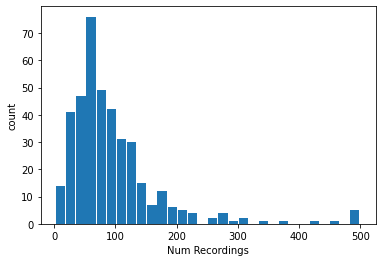

In [4]:
train=metadata.query('rating >= 4.0')

#lets see the distribution of count numbers
rec_count=pd.Series(train.primary_label.value_counts())
plt.hist(rec_count.values,width=15,bins=30)
plt.xlabel('Num Recordings')
plt.ylabel('count')

**I will use recordings with more than 150 instances.**

In [5]:
count_gt_100=rec_count[rec_count.values>150].index

#taking the data that has atleast 100 recordings rated >4:

train_ds=train[train['primary_label'].isin(count_gt_100)]
print(f'Number of species in data are : {train_ds.primary_label.nunique()}')
print(f'Number of audio samples : {len(train_ds)}')

Number of species in data are : 52
Number of audio samples : 12957


# Extracting Mel Spectrograms:

**Augmenting Data using Audiomentations Library**

In [6]:
#Audio Augmentation:
augmentations = Compose([
            FrequencyMask(min_frequency_band=0.005, max_frequency_band=0.10, p=0.25),
            TimeStretch(min_rate=0.15,max_rate=.25,p=0.25),
            AddGaussianSNR(min_SNR=0.001, max_SNR=.25, p=0.25)])

**Loading Data as mel-spectrograms**

In [7]:
#Global Params
Sample_rate = 32000
Signal_length = 5 # seconds
shape= (64, 256) # height x width
FMIN = 500
FMAX = 12500
hop_len=(Sample_rate* Signal_length // (shape[1]-1))

#Number of species in data
num_classes=train_ds.primary_label.nunique()


In [8]:
#making new dir to save spectrograms
cwd=os.path.abspath(os.getcwd())

os.mkdir(os.path.join(cwd,'Mel_specs'))

spec_dir=os.path.join(cwd,'Mel_specs')
spec_dir

'/kaggle/working/Mel_specs'

In [9]:
#function to save stfts

def save_stft(path,label=None,idx=None,Augment=False,dir_path=spec_dir):
    '''extracting mel-specs from given audio data and saving them to given folder'''
    
    
    #loading files:
    if label:
        file_path=os.path.join(path,label,idx)
    else:
        file_path=path
        
        
    sig,sr=librosa.load(file_path,sr=Sample_rate)
    
    stft_id=[]
    labels=[]
    n=0
    for i in range(0,len(sig),int(Signal_length*Sample_rate)):
        
        window = sig[i:i + int(Signal_length * Sample_rate)]

        # End of signal
        if len(window) < int(Signal_length * Sample_rate):
            break
            
            
            
        #Augment :   
        if Augment:
            window=augmentations(window,sample_rate=sr)
            
        # extracting mel-spectrograms:
        mel_spec = librosa.feature.melspectrogram(window,sr,n_mels=shape[0],
                                                hop_length=hop_len,
                                                fmin=FMIN,fmax=FMAX)
        
        mel_spec = librosa.core.amplitude_to_db(mel_spec,ref=np.max)
        
        # Normalize
        mel_spec -= mel_spec.min()
        mel_spec /= mel_spec.max()
        
        
        #saving Image
        
        #image_id
        ids=idx.split('.')[0]
        
        save_id=f'{ids}_{n}.jpg'
        save_path=os.path.join(dir_path,save_id)
        
        n+=1
        
        image = Image.fromarray(mel_spec * 255.0).convert("L")
        image.save(save_path)
        
        #saving_image ids and labels
        stft_id.append(save_id)
        labels.append(label)
        
    return stft_id,labels

**extracting specs for selected species**

In [10]:
spec_ids=[]
labels=[]
num_species=train_ds.primary_label.nunique()
for i,ids in enumerate(train_ds.primary_label.unique()):
    
    spec_df=train_ds[train_ds.primary_label==ids]
    
    #taking lesser number of samples from each species:
    
#     sampling n from given species
    n=int(len(spec_df)/3)
    
    for sound_ids in spec_df['filename'].sample(n):
        spec_id,label=save_stft(path=train_dir,label=ids,idx=sound_ids,Augment=True)
        
        #appending to final list:
        spec_ids.extend(spec_id)
        labels.extend(label)
        

assert len(spec_ids) == len(labels)
len(labels)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


49672

**saving ids and labels saved for further use**

In [11]:
#making a dataframe of recording_ids and labels:
train_specs=pd.DataFrame({'Image_Id':spec_ids,'label':labels})

del spec_ids, labels ; gc.collect()

#saving csv for further use:
train_specs.to_csv('train_specs.csv',index=False)
train_specs.head()

,Image_Id,label
0,XC165310_0.jpg,amerob
1,XC165310_1.jpg,amerob
2,XC165310_2.jpg,amerob
3,XC165310_3.jpg,amerob
4,XC165310_4.jpg,amerob


**checking some sample Images**

In [12]:
sampled_df=train_specs.sample(25)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


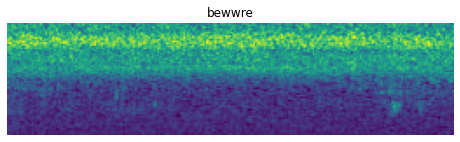

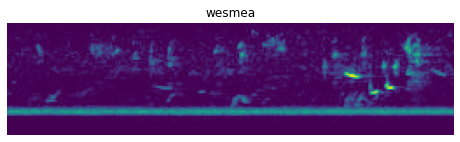

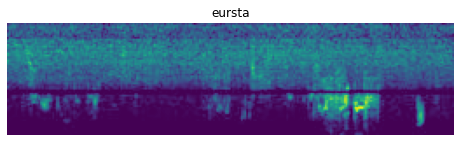

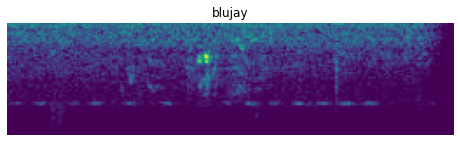

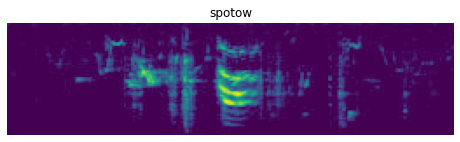

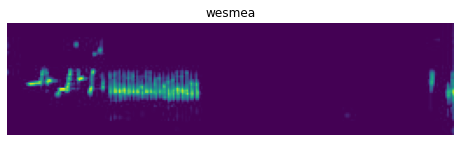

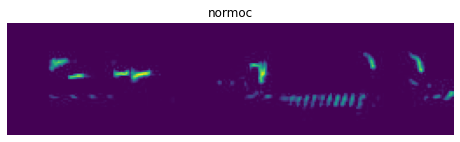

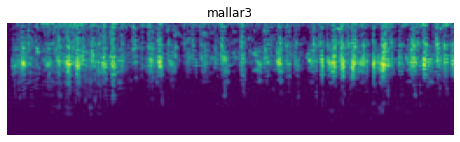

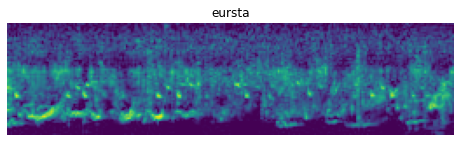

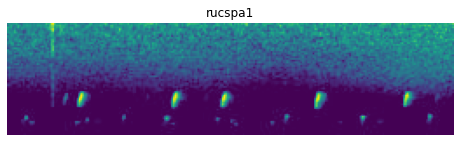

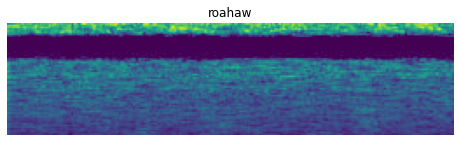

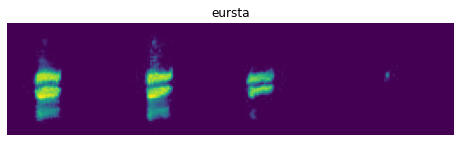

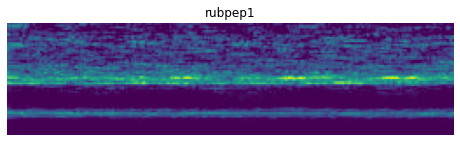

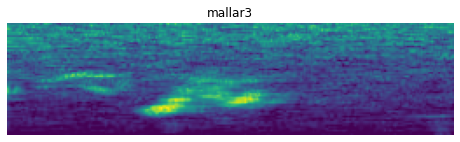

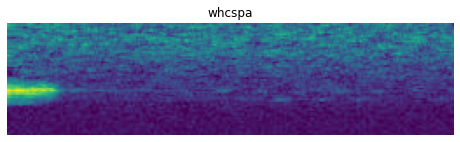

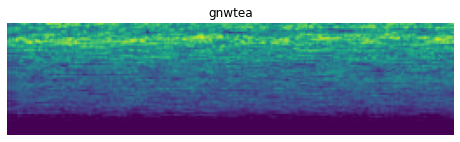

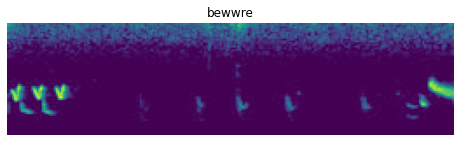

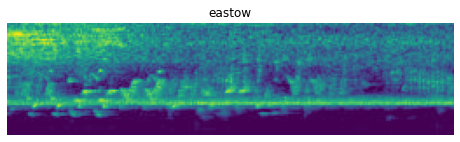

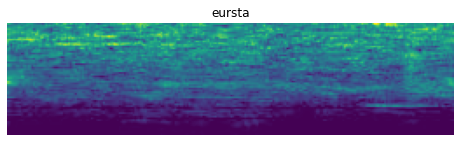

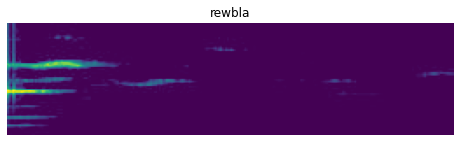

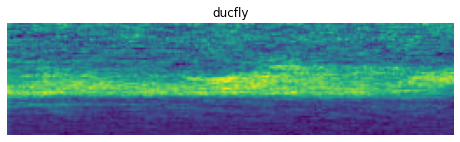

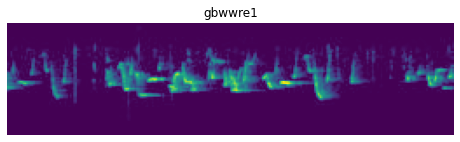

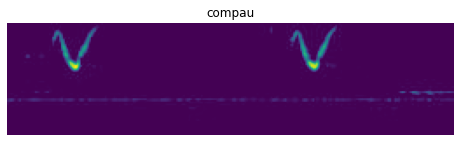

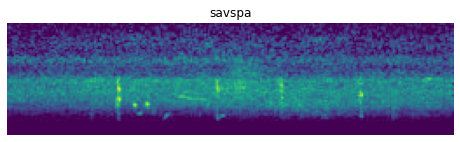

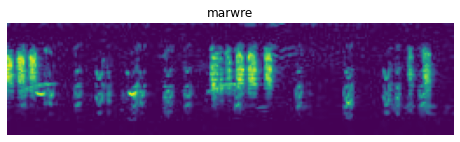

In [13]:
def show_image(path,title):
    plt.subplots(figsize=(8,4))
    image=Image.open(path)
    
    plt.title(name)
    plt.axis('off')
    plt.grid(b=None)
    plt.imshow(image)
    
for i,row in sampled_df.iterrows():
    idx=row.Image_Id
    name=row.label
    show_image(os.path.join(spec_dir,idx),name)

**Will do the training and inference part in a seperate notebook, linked above.**